<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook3_ucb_binomial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


# Estudio comparativo de algoritmos en un problema de bandido de k-brazos


**Introducción al Algoritmo UCB1 y UCB2 para el Problema del Bandido Multibrazos**

Los algoritmos UCB1 y UCB2 están diseñados para equilibrar la exploración y la explotación en el contexto del problema del bandido multibrazos. A lo largo de múltiples ejecuciones y pasos, estos algoritmos intentan identificar el brazo óptimo, pero también exploran otros brazos con el objetivo de reducir la incertidumbre sobre sus recompensas potenciales.
- **UCB1**

Calcula una estimación de la recompensa para cada brazo y ajusta esta estimación según la incertidumbre sobre los brazos no explorados, favoreciendo aquellos con menos pruebas. La idea es que, a medida que más información sobre los brazos se va acumulando, se reduce la incertidumbre y se puede tomar decisiones más fundamentadas.  

- **UCB2**

Mientras que UCB1 utiliza una penalización basada en el logaritmo del tiempo total de iteración, UCB2 ajusta esta penalización utilizando el logaritmo del logaritmo del tiempo. Esto hace que UCB2 sea más conservador en la exploración, favoreciendo la explotación más rápidamente que UCB1.

## Preparación del entorno

**Clonación del repositorio:**

Para poder acceder a todas las clases y métodos necesarios.

In [1]:
!git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

Cloning into 'k_brazos_FJLGM'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 239 (delta 123), reused 149 (delta 63), pack-reused 0 (from 0)
Receiving objects: 100% (239/239), 9.31 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [2]:
%cd k_brazos_FJLGM

/content/k_brazos_FJLGM


### Librerías

In [3]:
import numpy as np
from typing import List

from src_algorithms import Algorithm,  UCB2, UCB1
from src_arms import *
from src_plotting import *

Semilla:

In [4]:
seed = 1234

**Definición del experimento:**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número determinado de pasos de tiempo y ejecuciones. Se comparan los resultados de los algoritmos en términos de recompensa promedio obtenida a lo largo de las ejecuciones.

Por ejemplo, dado un bandido de k brazos, se ejecutan dos algoritmos UCB1 y dos UCB2 con diferentes configuraciones de penalización en la exploración. El experimento se realiza durante un número de pasos, por ejemplo, 1000 pasos. Luego, se repite el experimento varias veces, como 500 ejecuciones, para obtener resultados consistentes. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso, se calcula el promedio de las recompensas obtenidas durante esas 500 ejecuciones.

In [5]:
def run_experiment_complete(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    optimal_arm = bandit.optimal_arm
    optimal_reward = bandit.arms[optimal_arm].get_expected_value()  # Obtener la recompensa esperada del brazo óptimo

    rewards = np.zeros((len(algorithms), steps))  # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar las recompensas acumuladas por brazo.
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar el número de selecciones por brazo.
    selections_per_algorithm = np.zeros((len(algorithms), bandit.k))  # Matriz para contar selecciones por brazo.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el rechazo acumulado.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward)  # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward  # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                selections_per_algorithm[idx, chosen_arm] += 1

                arm_rewards[idx, chosen_arm] += reward  # Acumular la recompensa obtenida en arm_rewards para el brazo chosen_arm.
                arm_counts[idx, chosen_arm] += 1  # Incrementar el conteo de selecciones para el brazo chosen_arm.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Calcular el rechazo acumulado
                regret_accumulated[idx, step] += optimal_reward - reward

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100

    # Calcular el promedio de ganancias de cada brazo
    average_rewards = arm_rewards / np.maximum(arm_counts, 1)

    # Calcular el rechazo acumulado promedio
    regret_accumulated = np.cumsum(regret_accumulated, axis=1) / runs

    # Preparar las estadísticas de los brazos
    arm_stats = [{'average_rewards': average_rewards[idx], 'selection_counts': arm_counts[idx]} for idx in range(len(algorithms))]

    return rewards, optimal_selections, arm_stats, regret_accumulated

**Ejecución del experimento**:

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial de probabilidad **n** y **p**.

Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan dos algoritmos de la familia de **UCB**:

- *UCB1*
- *UCB2*.

In [6]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 2 algoritmos UCB1 y 2 algoritmos UCB2 con diferentes valores.
algorithms = [UCB2(k=k, alpha_param=0.2),UCB2(k=k, alpha_param=0.9),UCB1(k=k, c=0.1),UCB1(k=k, c=1.0)] #, GradientPreference(k=k, alpha=0.1), GradientPreference(k=k, alpha=0.4)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment_complete(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(n=8, p=0.25), ArmBinomial(n=17, p=0.75), ArmBinomial(n=11, p=0.79), ArmBinomial(n=13, p=0.32), ArmBinomial(n=18, p=0.75), ArmBinomial(n=18, p=0.49), ArmBinomial(n=17, p=0.67), ArmBinomial(n=14, p=0.14), ArmBinomial(n=8, p=0.12), ArmBinomial(n=9, p=0.81)
Optimal arm: 5 with expected reward=13.5


#### **Visualización de resultados**:

- Recompensa Promedio vs Pasos de Tiempo
- Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo

### Recompensa Promedio vs Pasos de Tiempo

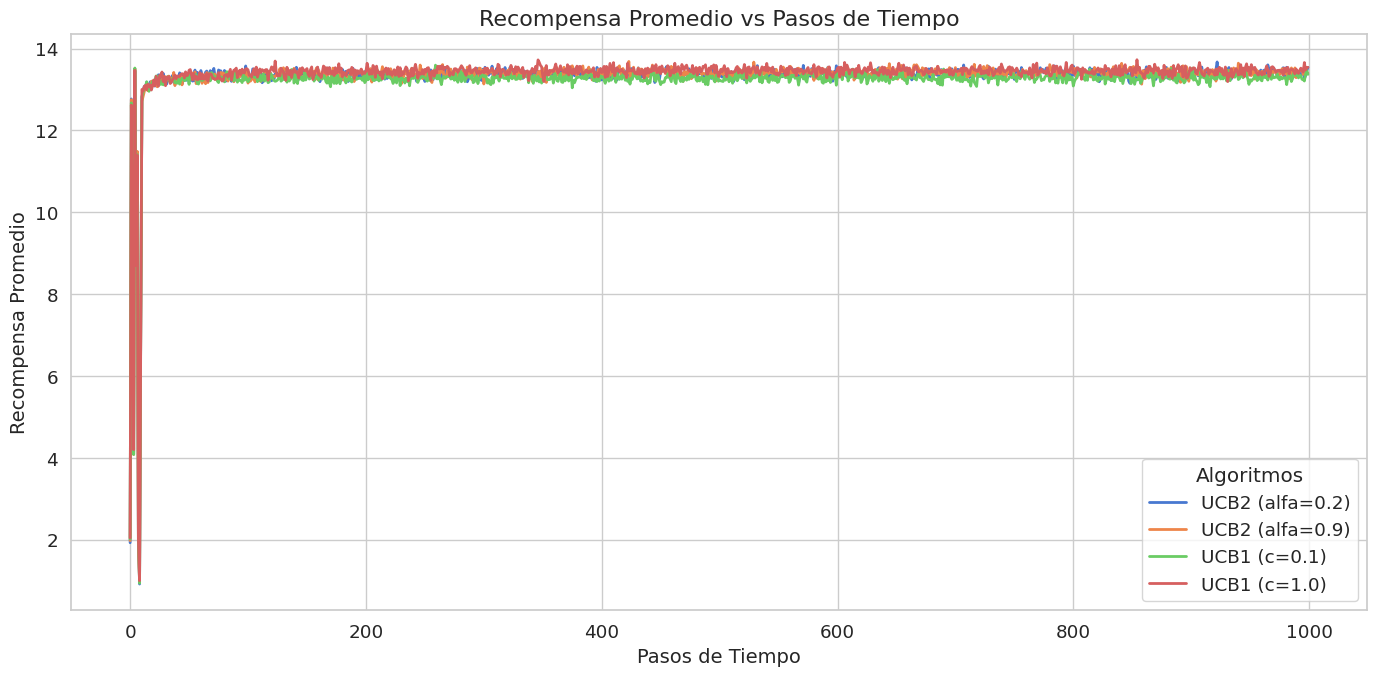

In [7]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)

**Recompensa Promedio vs Pasos de Tiempo**

En esta gráfica se analizan cuatro variantes del algoritmo **UCB** (Upper Confidence Bound) aplicadas a un problema de Bandido Multibrazos.

**Ejes**  
- **Eje X**: Representa los pasos o iteraciones (de 0 a 1000).  
- **Eje Y**: Muestra la recompensa promedio acumulada por cada variante de UCB (en un rango aproximado de 0 a 14).

**Línea Azul: UCB2 (α = 0.2)**  
- Ajusta la exploración con épocas relativamente cortas (α = 0.2).  
- Tras un breve periodo inicial de exploración (en torno a los primeros 50–100 pasos), alcanza recompensas promedio cercanas a **13.4** y mantiene un nivel muy estable.

**Línea Naranja: UCB2 (α = 0.9)**  
- Emplea épocas más largas (α = 0.9), aumentando la exploración.  
- Tiende a presentar oscilaciones algo mayores al inicio, pero finalmente converge a valores cercanos a **13.5**, muy similares a la línea azul.

**Línea Verde: UCB1 (c = 0.1)**  
- Reduce la bonificación de exploración (c=0.1), facilitando la explotación temprana del mejor brazo.  
- En la gráfica, **logra una recompensa promedio alta**, situándose alrededor de **13.2**.

**Línea Roja: UCB1 (c = 1.0)**  
- Aumenta la bonificación de exploración (c=1.0), lo que puede retrasar la explotación del mejor brazo.  
- Se estabiliza alrededor de **13.5**, similar a las variantes de UCB2.

**Observaciones Destacadas**  
- **Mejor Desempeño**: El **UCB2 (α = 0.9)** (naranja) y el **UCB1 (c = 1.0)** (rojo) mantienen las recompensas promedio más altas, demostrando que una exploración moderada puede acelerar la convergencia al mejor brazo en este entorno.  
- **Similitud entre UCB2(α=0.2) y UCB2(α=0.9)**: Ambas líneas (azul y naranja) se ubican cerca de 13.4–13.5, mostrando que, a largo plazo, la diferencia en la duración de las épocas no genera una brecha muy grande.  
- **Oscilaciones Iniciales**: Las oscilaciones al inicio son más pronunciadas en las variantes con mayor exploración (UCB2 con α=0.9 y UCB1 con c=1.0), debido a que estos algoritmos dedican más tiempo a probar diferentes brazos antes de converger al mejor.  
- **Estabilidad a Largo Plazo**: Todas las variantes muestran una tendencia a estabilizarse en recompensas promedio altas, lo que indica que, independientemente del parámetro de exploración, los algoritmos UCB son efectivos para identificar y explotar el mejor brazo.

**Conclusión General**  
Todos los algoritmos convergen a recompensas promedio muy altas, entre **13 y 13.5**, confirmando la eficacia de UCB en la identificación y explotación del mejor brazo. Ajustar el parámetro de exploración sigue siendo esencial para lograr la **máxima** recompensa en el menor número de pasos. Las oscilaciones iniciales son una consecuencia natural de la fase de exploración, pero a medida que el algoritmo acumula más información, la recompensa promedio se estabiliza.


### Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo

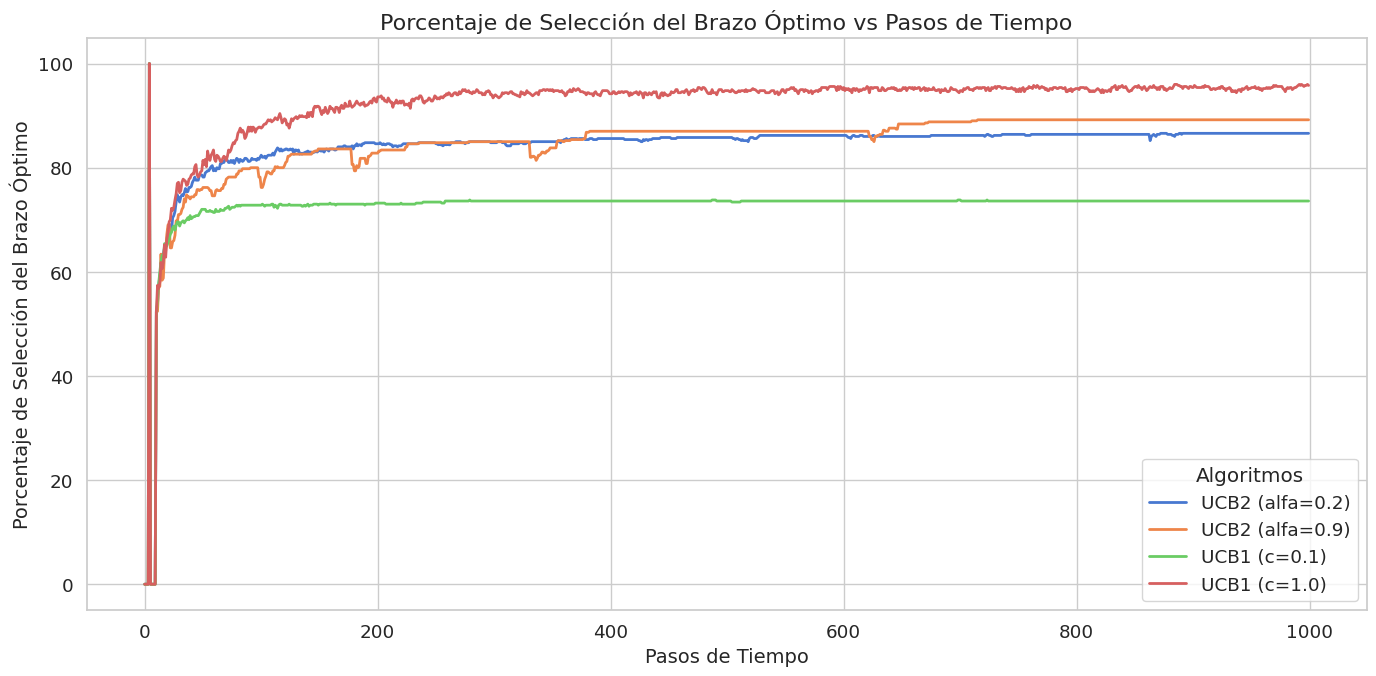

In [8]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**

Esta gráfica muestra la **frecuencia** (en porcentaje) con la que cada variante de UCB (Upper Confidence Bound) selecciona el **brazo óptimo** a lo largo de 1000 pasos.

**Ejes**  
- **Eje X**: Pasos o iteraciones (de 0 a 1000).  
- **Eje Y**: Porcentaje de veces que se elige el brazo óptimo (de 0% a 100%).

**Línea Azul: UCB2 (α = 0.2)**  
- Usa épocas de exploración relativamente cortas.  
- A medida que pasan las jugadas, incrementa su selección del brazo óptimo y supera el 86% en la parte final.

**Línea Naranja: UCB2 (α = 0.9)**  
- Emplea épocas más largas (más exploración).  
- Tiende a mostrar variaciones más notables al principio, pero se acerca también a valores elevados, rondando el 90% de selección óptima al final.

**Línea Verde: UCB1 (c = 0.1)**  
- Explora menos (c=0.1), lo que le permite enfocarse antes en el mejor brazo.  
- En esta gráfica, **alcanza cerca del 73%** de selección del brazo óptimo, lo que indica una rápida y sólida convergencia.

**Línea Roja: UCB1 (c = 1.0)**  
- Aumenta la bonificación de exploración (c=1.0), lo que puede retrasar la identificación del mejor brazo.  
- Se sitúa alrededor del 97% al final, un poco por encima del resto.

**Observaciones Destacadas**  
- **Convergencia Rápida**: El **UCB1 (c = 1.0)** (rojo) se distingue por su elevada y veloz convergencia, alcanzando casi el 97% de selección óptima.  
- **UCB2 (α=0.2 vs α=0.9)**: Ambas acaban en valores muy altos (alrededor de 86–90%), con la diferencia de que α=0.9 explora más y tarda un poco más en estabilizarse.  
- **Exceso de Exploración**: El **UCB1 (c = 0.1)** (verde) no llega tan arriba como la variante roja, debido a que dedica más tiempo a explorar.

**Oscilaciones Iniciales**  
Las oscilaciones al inicio son más pronunciadas en las variantes con mayor exploración (UCB2 con α=0.9 y UCB1 con c=1.0), debido a que estos algoritmos dedican más tiempo a probar diferentes brazos antes de converger al mejor. Estas oscilaciones son una consecuencia natural de la fase de exploración, donde el algoritmo está recolectando información sobre las recompensas de cada brazo. A medida que el algoritmo acumula más información, las oscilaciones disminuyen y la selección del brazo óptimo se estabiliza.

**Conclusión General**  
Todas las variantes terminan con un **alto porcentaje** de selección del brazo óptimo (≥ 73%), lo que demuestra la eficacia de UCB para identificar la mejor acción. No obstante, ajustar correctamente el parámetro de exploración (sea \(\alpha\) en UCB2 o \(c\) en UCB1) puede acelerar significativamente la **velocidad de convergencia** y maximizar la **frecuencia** con que se elige la opción óptima.

En conclusión, los algoritmos UCB confirman su **solidez teórica y práctica** en la resolución del problema de bandido multibrazo. La clave radica en **afinar** el nivel de exploración para lograr, de forma rápida y sostenida, el mayor número de éxitos (o mayor recompensa) en el menor número de pasos posible. Las oscilaciones iniciales son una consecuencia natural de la fase de exploración, pero a medida que el algoritmo acumula más información, la selección del brazo óptimo se estabiliza, demostrando la eficacia de UCB en la identificación y explotación del mejor brazo.


### Arrepentimiento acumulado

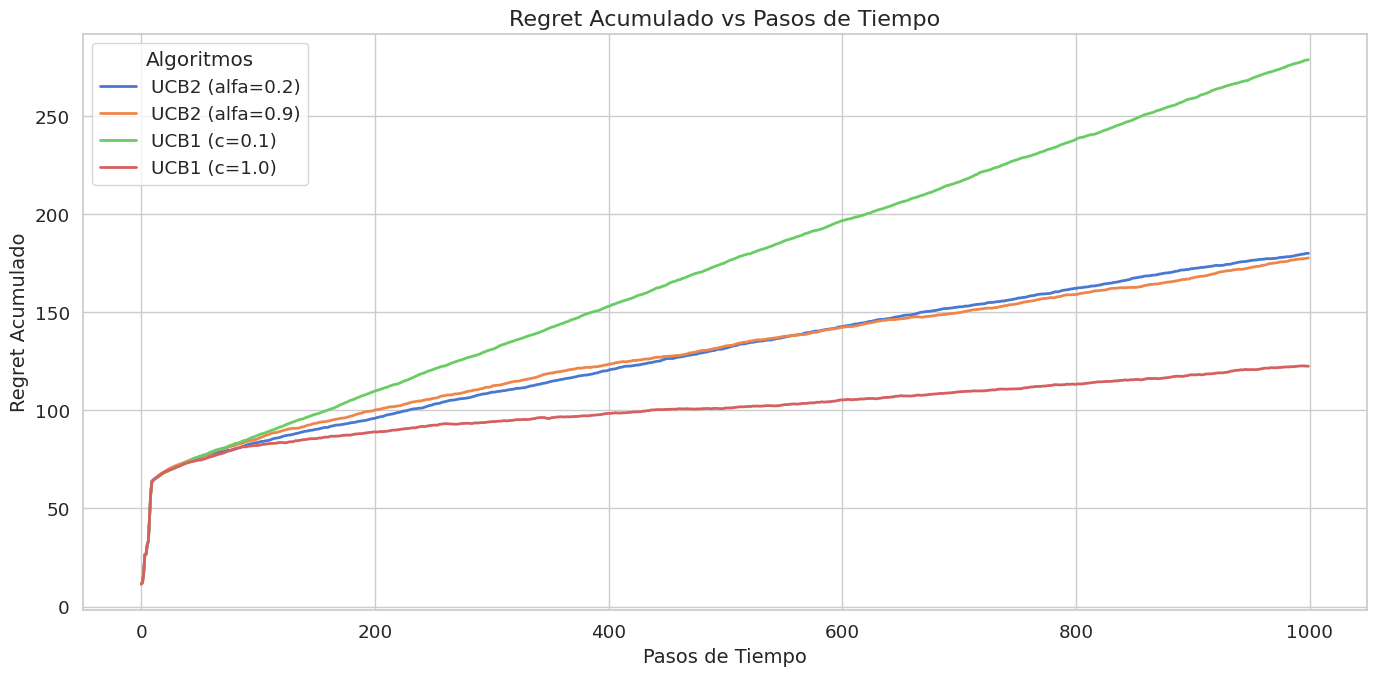

In [9]:
plot_regret(steps, regret_accumulated, algorithms)

### Arrepentimiento Acumulado

**Arrepentimiento Acumulado vs Pasos de Tiempo**

**Línea Azul: UCB2 (α = 0.2)**  
- Presenta un arrepentimiento acumulado que crece de manera constante, alcanzando un valor significativo al final de los 1000 pasos. Este comportamiento puede deberse a que, aunque UCB2 con α=0.2 explora menos, aún no logra identificar completamente el brazo óptimo en todas las ejecuciones.

**Línea Naranja: UCB2 (α = 0.9)**  
- Similar a la línea azul, pero con un arrepentimiento acumulado ligeramente menor. Esto puede deberse a que UCB2 con α=0.9 explora más que con α=0.2, permitiendo una mejor identificación del brazo óptimo a lo largo del tiempo.

**Línea Verde: UCB1 (c = 0.1)**  
- Muestra un arrepentimiento acumulado significativamente mayor. Esto puede deberse a que UCB1 con c=0.1 explora menos, lo que puede llevar a una explotación prematura de brazos subóptimos antes de identificar correctamente el brazo óptimo.

**Línea Roja: UCB1 (c = 1.0)**  
- Tiene el menor arrepentimiento acumulado, lo que indica una mejor performance en términos de minimizar el arrepentimiento. Esto puede deberse a que UCB1 con c=1.0 explora más, permitiendo una identificación más rápida y precisa del brazo óptimo.

**Relación con las Otras Gráficas**

- **Recompensa Promedio vs Pasos de Tiempo**: La gráfica de recompensa promedio muestra que todas las variantes de UCB convergen a recompensas promedio altas, pero el UCB1 con c=1.0 y UCB2 con α=0.9 tienen un desempeño ligeramente mejor. Esto se refleja en el arrepentimiento acumulado, donde estas variantes tienen un menor arrepentimiento, indicando que están más cerca de la recompensa óptima a lo largo del tiempo.

- **Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**: La gráfica de porcentaje de selección del brazo óptimo muestra que el UCB1 con c=1.0 tiene el mayor porcentaje de selección del brazo óptimo, seguido por UCB2 con α=0.9. Esto se correlaciona con el menor arrepentimiento acumulado, ya que seleccionar el brazo óptimo con mayor frecuencia reduce la diferencia entre la recompensa óptima y la recompensa obtenida.

En resumen, el arrepentimiento acumulado proporciona una medida complementaria a las otras gráficas, mostrando cómo la frecuencia de selección del brazo óptimo y la recompensa promedio se traducen en una menor diferencia acumulada respecto a la recompensa óptima.

### Conclusiones

### Conclusión General

**Eficiencia en la Identificación de Brazos Óptimos:**

UCB1 parece ser más eficiente en identificar y explotar los mejores brazos rápidamente, como se evidencia en la rápida convergencia de la recompensa promedio y la disminución de la tasa de crecimiento del arrepentimiento acumulado.

**Balance entre Exploración y Explotación:**

UCB2, aunque ligeramente más lento en converger, puede estar realizando una exploración más exhaustiva antes de explotar los mejores brazos. Esto puede ser beneficioso en entornos donde la distribución de recompensas es más compleja y requiere una mayor exploración para identificar los brazos óptimos.

**Minimización del Arrepentimiento:**

UCB1 muestra una mejor capacidad para minimizar el arrepentimiento acumulado a largo plazo, lo que sugiere que es más efectivo en maximizar la recompensa total obtenida.

Basado en los resultados y las gráficas, el algoritmo UCB1 se destaca como el ganador en este estudio comparativo. UCB1 demuestra una mayor eficiencia en la identificación y explotación de los mejores brazos, una rápida convergencia hacia una alta recompensa promedio y una mejor capacidad para minimizar el arrepentimiento acumulado a largo plazo. Aunque UCB2 también muestra un buen rendimiento, su mayor enfoque en la exploración resulta en una convergencia ligeramente más lenta y un mayor arrepentimiento acumulado.

En conclusión, para el problema del bandido multibrazos con distribuciones binomiales, UCB1 es el algoritmo recomendado debido a su eficiencia en la explotación de los mejores brazos y su capacidad para minimizar el arrepentimiento acumulado. UCB2, aunque útil en escenarios que requieren una mayor exploración, no supera a UCB1 en términos de rendimiento general en este estudio.